In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader,random_split,Dataset,ConcatDataset
import torchvision
from torchvision.datasets import DTD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2
import torchvision.transforms.functional as F_transforms
import os
import csv
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
!pip install pytorch-metric-learning
import torch.backends.cudnn as cudnn
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
try:
    import apex
    from apex import amp, optimizers
except ImportError:
    pass


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 9.2 MB/s eta 0:00:00


#Drive Bağlantısı


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Paths

In [ ]:
drivePath = '/content/drive/MyDrive/Results'

os.makedirs(drivePath, exist_ok=True)

In [ ]:
checkpointDir = '/content/drive/MyDrive/checkpoints'
os.makedirs(checkpointDir, exist_ok=True)

In [ ]:
dataDir="/content/drive/MyDrive/data"

#Data Augmentation

In [ ]:
class twoCropTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

#Tranformation Build

In [ ]:
def buildTransforms(secondStage:bool):
    if secondStage:
        trainTransforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
        validTransforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
        testTransforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
        oodTestTransforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
        transforms_dict = {
            "trainTransforms": trainTransforms,
            'testTransforms': testTransforms,
            'oodTestTransforms': oodTestTransforms
        }
    else:
        trainTransforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
        testTransforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
        oodTrainTransforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
        oodTestTransforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
        transforms_dict = {
            "trainTransforms": trainTransforms,
            'testTransforms': testTransforms,
            'oodTrainTransforms': oodTrainTransforms,
            'oodTestTransforms': oodTestTransforms
        }

    return transforms_dict

#Data sets


In [ ]:
"""class SupConDatasetCifar10(torchvision.datasets.CIFAR10):
    def __init__(self, data_dir, train, transform, secondStage):
        super().__init__(root=data_dir, train=train, download=True, transform=transform)

        self.secondStage = secondStage
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]

        if self.secondStage:
            image = self.transform(image=image)['image']
        else:
            image = self.transform(image)

        return image, label


class SupConDatasetDTD(torchvision.datasets.DTD):
    def __init__(self, data_dir, train, transform, secondStage):
        super().__init__(root=data_dir, split=train, download=True, transform=transform)

        self.secondStage = secondStage
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]

        if self.secondStage:
            image = self.transform(image=image)['image']
        else:
            image = self.transform(image)

        return image, label


DATASETS = {'cifar10': SupConDatasetCifar10,
            'DTD': SupConDatasetDTD}"""

In [ ]:
"""def createSupconDataset(dataset_name, dataDir, train, transform, secondStage):
    try:
        return DATASETS[dataset_name](dataDir, train, transform, secondStage)
    except KeyError:
        Exception('There is no such data set')"""

#Loaders

In [ ]:
def buildLoaders(data_dir, transforms, batchSize, numWorkers, secondStage=False):

    if secondStage:
        trainDataset = torchvision.datasets.CIFAR10( root=data_dir, train=True,
                                               transform=transforms['trainTransforms'])
        testDataset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                               transform=transforms['testTransforms'])
        valDataset,testDataset = random_split(
            testDataset,
            [int(len(testDataset) * 0.5), len(testDataset) - int(len(testDataset) * 0.5)]
        )
        oodTestDataset = DTD( root=data_dir, split="test",
                                               transform=transforms['oodTestTransforms'])

    else:
        trainDataset = torchvision.datasets.CIFAR10( root=data_dir, train=True,
                                               transform=twoCropTransform(transforms['trainTransforms']))
        testDataset = torchvision.datasets.CIFAR10( root=data_dir, train=False,
                                               transform=transforms['testTransforms'])
        valDataset,testDataset = random_split(
            testDataset,
            [int(len(testDataset) * 0.5), len(testDataset) - int(len(testDataset) * 0.5)]
        )

        oodTrainDataset = DTD( root=data_dir, split="train",
                                               transform=twoCropTransform(transforms['oodTrainTransforms']))
        oodTestDataset = DTD( root=data_dir, split="test",
                                               transform=transforms['oodTestTransforms'])


    if not secondStage:
        oodTrainLoader = DataLoader(
            oodTrainDataset, batch_size=batchSize, shuffle=True,
            num_workers=numWorkers, pin_memory=True)
    trainLoader = DataLoader(
        trainDataset, batch_size=batchSize, shuffle=True,
        num_workers=numWorkers, pin_memory=True)
    validLoader = DataLoader(
        valDataset, batch_size=batchSize, shuffle=True,
        num_workers=numWorkers, pin_memory=True)
    testLoader = DataLoader(
        testDataset, batch_size=batchSize, shuffle=True,
        num_workers=numWorkers, pin_memory=True, drop_last=True)
    oodtestLoader = DataLoader(
        oodTestDataset, batch_size=batchSize, shuffle=True,
        num_workers=numWorkers, pin_memory=True, drop_last=True)

    if secondStage:
        return {'trainLoader': trainLoader, 'validLoader': validLoader, "testLoader":testLoader,"oodtestLoader":oodtestLoader}
    return {'trainLoader': trainLoader, 'validLoader': validLoader, "testLoader":testLoader,"oodTrainLoader":oodTrainLoader,"oodTestLoader":oodtestLoader}


#Checkpoint

In [ ]:
def save_checkpoint(model, optimizer,scheduler, epoch, loss, checkpoint_dir,accuracy=None, filename='checkpointLossRange.pth'):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        'accuracy':accuracy
    }, checkpoint_path)
    print(f'Checkpoint saved at epoch {epoch} to {checkpoint_path}')

#Embeddings

In [ ]:
def computeEmbeddings(loader, model, scaler=None):
    total_embeddings = np.zeros((len(loader)*loader.batch_size, 128))
    total_labels = np.zeros(len(loader)*loader.batch_size)

    for idx, (images, labels) in enumerate(loader):
        images = images.cuda()
        bsz = labels.shape[0]
        if scaler:
            with torch.cuda.amp.autocast():
                _,embed = model(images)
                total_embeddings[idx * bsz: (idx + 1) * bsz] = embed.detach().cpu().numpy()
                total_labels[idx * bsz: (idx + 1) * bsz] = labels.detach().numpy()
        else:
            _,embed = model(images)
            total_embeddings[idx * bsz: (idx + 1) * bsz] = embed.detach().cpu().numpy()
            total_labels[idx * bsz: (idx + 1) * bsz] = labels.detach().numpy()

        del images, labels, embed
        torch.cuda.empty_cache()

    return np.float32(total_embeddings), total_labels.astype(int)

In [ ]:
import torch

def computePrototypes(embeddings, labels, num_classes):

    embedding_dim = embeddings.size(1)
    prototypes = torch.zeros(num_classes, embedding_dim)
    labels = torch.cat([labels, labels], dim=0)
    # Count samples per class to calculate the mean
    class_counts = torch.zeros(num_classes, dtype=torch.long)

    # Accumulate embeddings per class
    for i in range(num_classes):
        class_mask = (labels == i)
        class_embeddings = embeddings[class_mask]
        class_counts[i] = class_mask.sum()

        if class_counts[i] > 0:
            prototypes[i] = class_embeddings.mean(dim=0)

    return prototypes


#Set Model

**Losses**

In [ ]:
class TightnessLossEncoderID(nn.Module):
    def __init__(self):
        super(TightnessLossEncoderID, self).__init__()

    def forward(self, features,prototypes):
        features_norm = F.normalize(features, p=2, dim=1)
        prototypes = F.normalize(prototypes, p=2, dim=1)
        similarity = torch.matmul(-features_norm, prototypes.t())
        loss=torch.mean(similarity)
        return loss


class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).cuda()
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().cuda()
        else:
            mask = mask.float().cuda()

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        mask = mask.repeat(anchor_count, contrast_count)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).cuda(),
            0
        )
        mask = mask * logits_mask

        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))


        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

class ContrastProjectionOOD(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastProjectionOOD, self).__init__()
        self.temperature = temperature
    def forward(self, projectionOOD, projectionID):
        projectionOOD=F.normalize(projectionOOD, p=2, dim=1)
        projectionID=F.normalize(projectionID, p=2, dim=1)
        projectionID=torch.cat(torch.unbind(projectionID, dim=1), dim=0)
        projectionOOD=torch.cat(torch.unbind(projectionOOD, dim=1), dim=0)
        similarity = torch.matmul(projectionOOD, projectionID.t())/self.temperature
        contrastiveLoss=torch.mean(torch.logsumexp(similarity,dim=1))
        return contrastiveLoss
class ContrastEncoderOOD(nn.Module):
    def __init__(self,temperature=0.07):
        super(ContrastEncoderOOD, self).__init__()
        self.temperature = temperature

    def forward(self, featuresOOD,prototypes):
        featuresOOD=F.normalize(featuresOOD, p=2, dim=1)
        prototypes=F.normalize(prototypes, p=2, dim=1)
        similarity = torch.matmul(featuresOOD, prototypes.t())/self.temperature
        contrastiveLoss=torch.mean(torch.logsumexp(similarity,dim=1))
        return contrastiveLoss

**Models**

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ProjectionHead, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim,in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        x = self.fc(x)
        return F.normalize(x, dim=1)

class ResNetWithProjection(nn.Module):
    def __init__(self, backbone, proj_dim=128):
        super(ResNetWithProjection, self).__init__()
        self.encoder = nn.Sequential(*list(backbone.children())[:-1])
        self.projectionHead = ProjectionHead(backbone.fc.in_features, proj_dim)


    def forward(self, x):
        features = self.encoder(x).squeeze()
        projections = self.projectionHead(features)
        return features, projections


class LinearClassifier(nn.Module):
    def __init__(self, backbone, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.backbone = backbone
        feat_dim = self.backbone.fc.in_features
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, features):
        x=self.fc(features)
        return x

In [ ]:
def setModel(backbone,temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
    model = ResNetWithProjection(backbone).cuda()
    classifier=LinearClassifier(backbone)



    supconLost=SupervisedContrastiveLoss(temperature=0.07, contrast_mode='all',
                 base_temperature=0.07)
    tightnessLoss=TightnessLossEncoderID()
    contProj=ContrastProjectionOOD()
    contEnc=ContrastEncoderOOD()
    criterion = torch.nn.CrossEntropyLoss()



    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model.encoder = torch.nn.DataParallel(model.encoder)
        model = model.cuda()
        classifier = classifier.cuda()
        supconLost = supconLost.cuda()
        tightnessLoss = tightnessLoss.cuda()
        contProj = contProj.cuda()
        contEnc = contEnc.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True
    tools={"model":model,
           "classifier":classifier,
           "supconLost":supconLost,
           "tightnessLoss":tightnessLoss,
           "contProj":contProj,
           "contEnc":contEnc,
           "criterion":criterion
           }

    return tools

#Train Loop

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch=450):
    model.train()

    totalLoss=0
    for idx, (images, labels) in enumerate(train_loader,1):

        images = torch.cat([images[0], images[1]], dim=0)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        bsz = labels.shape[0]


        fI,zI = model(images)
        zI1, zI2 = torch.split(zI, [bsz, bsz], dim=0)
        zI = torch.cat([zI1.unsqueeze(1), zI2.unsqueeze(1)], dim=1)
        loss = criterion(zI, labels)
        totalLoss+=loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (idx) % 30 == 0:
            print(f'Train: [{epoch}][{idx}/{len(train_loader)}]\t'
                  f'loss {loss:.3f} Avg loss ({totalLoss/idx:.3f})')
    return totalLoss/len(train_loader)





#Fine Tune Loop

In [ ]:
def fineTune(train_loader,trainOODLoader,num_classes, model, criterion,tightness,contrastiveEnc,contrastiveProj,alpha,gamma, optimizer,epoch=50):
    model.train()

    totalFTLoss=0
    idx=0
    for (images, labels), (imagesOOD, labelsOOD) in zip(train_loader, trainOODLoader):

        images = torch.cat([images[0], images[1]], dim=0)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        bsz = labels.shape[0]
        bszOOD=labelsOOD.shape[0]


        fI,zI = model(images)
        zI1, zI2 = torch.split(zI, [bsz, bsz], dim=0)
        zI = torch.cat([zI1.unsqueeze(1), zI2.unsqueeze(1)], dim=1)
        lossSupcon = criterion(zI, labels)



        imagesOOD = torch.cat([imagesOOD[0], imagesOOD[1]], dim=0)
        if torch.cuda.is_available():
            imagesOOD = imagesOOD.cuda()



        prototypes = computePrototypes(fI, labels, num_classes).cuda()


        fO,zO = model(imagesOOD)
        zO1, zO2 = torch.split(zO, [bszOOD, bszOOD], dim=0)
        zO = torch.cat([zO1.unsqueeze(1), zO2.unsqueeze(1)], dim=1)
        lossTightness = tightness(fI,prototypes)
        lossContrastProj = contrastiveProj(zO, zI)
        lossContrastEnc = contrastiveEnc(fO, prototypes)
        loss = lossSupcon + gamma * lossTightness + alpha * (lossContrastProj + lossContrastEnc)
        totalFTLoss+=loss



        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (idx + 1) % 30 == 0:
            print(f'Train: [{epoch}][{idx + 1}/{len(train_loader)}]\t'
                  f'loss {loss:.3f} Avg loss ({totalFTLoss/(idx+1):.3f})')

        idx+=1
    return totalFTLoss/len(train_loader)





#Linear Classifier

In [ ]:
def linearClassifierTrain(train_loader, model,classifier, criterion,optimizer, epoch=100):

    model.eval()
    classifier.train()
    totalLossLC=0
    correct=0
    total=0
    for idx,(xI, yI) in enumerate(train_loader,1):
        yI=yI.cuda()
        xI=xI.cuda()
        batchSize=yI.shape[0]
        with torch.no_grad():
            fI, _ = model(xI)
        fI = fI.detach()
        output=classifier(fI)
        loss = criterion(output, yI)
        predictions= torch.max(output, 1)[1].cuda()
        correct += (predictions == yI).sum().item()
        total+=len(yI)
        totalLossLC+=loss


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (idx) % 30 == 0:
            print(f'Train: [{epoch}][{idx}/{len(train_loader)}]\t'
                  f'loss {loss:.3f} Avg loss ({totalLossLC/idx:.3f})')

    return totalLossLC/len(train_loader), correct/total






In [ ]:
def linearClassifierVal(valLoader, model,classifier, criterion, epoch=100):

    model.eval()
    classifier.eval()
    totalValLoss=0
    correctVal=0
    totalVal=0
    with torch.no_grad():
      for idx,(xI, yI) in enumerate(valLoader,1):
        yI=yI.cuda()
        xI=xI.cuda()
        fI, _ = model(xI)
        output=classifier(fI)
        loss = criterion(output, yI)
        predictions = torch.max(output, 1)[1].cuda()
        correctVal += (predictions == yI).sum().item()
        totalVal+=len(yI)
        totalValLoss+=loss
    if (idx) % 30 == 0:
            print(f'Validation: [{epoch}][{idx}/{len(valLoader)}]\t'
                  f'validation loss {loss:.3f} Avg Validation loss ({totalValLoss/idx:.3f}) ')
    return totalValLoss/len(valLoader), correctVal/totalVal


#First Stage Main

In [ ]:
parameters={
    "dataLoader":{
        "batchSize":512,
        "numWorkers":2,
        "secondStage":False
    },
    "model":{
        "backbone":models.resnet18(pretrained=False),
        "projDim":128
    },
    "optimizer":{
        "lr":1e-3,
        "momentum":0.9,
        "weight_decay":1e-4
    },
    "scheduler":{
        "T_max":100,
        "eta_min":1e-4
    },
    "supConLoss":{
        "temperature":0.1
    },
    "optimizerCE":{
        "lr":0.01,
        "momentum":0.9,
        "weight_decay":1e-3
    },
    "schedulerCE":{
        "T_max":20,
        "eta_min":1e-2
    },
    "dataLoaderCE":{
        "batchSize":512,
        "numWorkers":2,
        "secondStage":True
    },
    "numClasses":10,
    "alpha":0.1,
    "gamma":1
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def main():


#train
    bestTrainLoss = float('inf')

    tranformers=buildTransforms(secondStage=False)
    loaders=buildLoaders(dataDir, tranformers, **parameters["dataLoader"])

    backbone = models.resnet18(pretrained=False)
    tools=setModel(backbone,**parameters["supConLoss"])
    model=tools["model"]
    supconLost=tools["supconLost"]






    optimizer = torch.optim.SGD(model.parameters(),**parameters["optimizer"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, **parameters["scheduler"])
    trainLosses = []
    for epoch in range(1,450+1):

        loss = train(loaders["trainLoader"], model, supconLost, optimizer, epoch)
        trainLosses.append(loss)
        scheduler.step()


        print(f'Epoch [{epoch}/450],    Learning Rate: {scheduler.get_last_lr()[0]:.4f},    Train Loss: {loss:.4f}')
        if loss < bestTrainLoss  :
            bestTrainLoss = loss
            save_checkpoint(model=model,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpointDir,filename='train_best_checkpoint.pth')

    save_checkpoint(model=model,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpointDir,filename='trainLast.pth')



    csv_path = os.path.join(drivePath, 'trainLosses.csv')

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Loss'])
        for epoch, loss in enumerate(trainLosses, 1):
            writer.writerow([epoch, loss.item()])

    print(f"Loss values saved to {csv_path}")


    plt.plot([loss.item() for loss in trainLosses], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function During Training')
    plt.legend()

    png_path = os.path.join(drivePath, 'lossPlot.png')

    plt.savefig(png_path)


    plt.show()
    print(f"Loss plot saved to {png_path}")







#Fine Tune
    best_fine_tune_loss = float('inf')


    tightnessLoss=tools["tightnessLoss"]
    contProj=tools["contProj"]
    contEnc=tools["contEnc"]



    fineTuningLosses = []
    for epoch in range(1,50+1):
        loss = fineTune(loaders["trainLoader"],loaders["oodTrainLoader"],parameters["numClasses"], model, supconLost,tightnessLoss,contEnc,contProj,parameters["alpha"],parameters["gamma"], optimizer,epoch)
        fineTuningLosses.append(loss)
        scheduler.step()


        print(f'Epoch [{epoch}/50],    Learning Rate: {scheduler.get_last_lr()[0]:.4f},    Train Loss: {loss:.4f}')
        if loss < best_fine_tune_loss  :
            best_fine_tune_loss = loss
            save_checkpoint(model=model,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpointDir,filename='fine_tune_best_checkpoint.pth')

    save_checkpoint(model=model,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpointDir,filename='fine_tuneLast.pth')



    csv_path = os.path.join(drivePath, 'fineTuningLosses.csv')

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Loss'])
        for epoch, loss in enumerate(fineTuningLosses, 1):
            writer.writerow([epoch, loss.item()])

    print(f"Loss values saved to {csv_path}")


    plt.plot([loss.item() for loss in trainLosses], label='Fine Tuning Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function During Fine Tuning')
    plt.legend()

    png_path = os.path.join(drivePath, 'fineTuningLossesPlot.png')

    plt.savefig(png_path)


    plt.show()
    print(f"Loss plot saved to {png_path}")




#Linear Classifier
    train_lossesCE = []
    val_lossesCE = []
    accuracyList=[]
    valAccuracyList=[]

    bestTrainLoss = float('inf')
    bestValLoss = float('inf')
    tranformers=buildTransforms(secondStage=True)
    loaders=buildLoaders(dataDir, tranformers, **parameters["dataLoaderCE"])
    criterion = tools["criterion"]

    classifier=tools["classifier"]
    optimizerCE = torch.optim.SGD(classifier.parameters(),**parameters["optimizerCE"])
    schedulerCE = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerCE,**parameters["schedulerCE"])


    for epoch in range(1,100+1):
        loss,accuracy = linearClassifierTrain(loaders["trainLoader"], model, classifier, criterion, optimizerCE,epoch)
        train_lossesCE.append(loss)
        val_lossesCE.append(accuracy)
        schedulerCE.step()

        valLoss,valAccuracy=linearClassifierVal(loaders["validLoader"], model, classifier, criterion,epoch)
        val_lossesCE.append(valLoss)
        valAccuracyList.append(valAccuracy)


        print(f'Epoch [{epoch+1}/100],Learning Rate: {schedulerCE.get_last_lr()[0]}, Train Loss: {loss:.4f}, Accuracy:{accuracy:.4f} \n ValLoss: {valLoss:.4f}, ValAccuracy: {valAccuracy:.4f}  ')
        if loss < bestTrainLoss  :
            bestTrainLoss = loss
            save_checkpoint(model=classifier,optimizer= optimizerCE,scheduler= schedulerCE,epoch= epoch,loss= loss,accuracy=accuracy,checkpoint_dir= checkpointDir,filename='trainCE_best_checkpoint.pth')
        if valLoss < bestValLoss  :
            bestValLoss = valLoss
            save_checkpoint(model=classifier,optimizer= optimizerCE,scheduler= schedulerCE,epoch= epoch,loss= loss,accuracy=accuracy,checkpoint_dir= checkpointDir,filename='trainCE_best_checkpointByValLoss.pth')

    save_checkpoint(model=model,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpointDir,filename='trainLastCE.pth')



    csv_path = os.path.join(drivePath, 'trainCELosses.csv')

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Loss',"Accuracy","ValLoss","ValAccuracy"])
        for epoch, loss in enumerate(train_lossesCE, 1):
            writer.writerow([epoch, loss.item(),accuracyList[epoch-1],val_lossesCE[epoch-1],valAccuracyList[epoch-1]])

    print(f"Loss values saved to {csv_path}")

    plt.plot([loss.item() for loss in train_lossesCE], label='Training CE Loss')
    plt.plot([loss.item() for loss in val_lossesCE], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function During Fine Tuning CE')
    plt.legend()

    png_path = os.path.join(drivePath, 'fineTuningCELossesPlot.png')

    plt.savefig(png_path)

    plt.show()
    print(f"Fine Tuning CE Loss plot saved to {png_path}")






if __name__ == '__main__':
    main()

Train: [1][30/98]	loss 6.952 Avg loss (7.039)
Train: [1][60/98]	loss 6.939 Avg loss (6.992)


KeyboardInterrupt: 

In [ ]:
csv_path = os.path.join(drivePath, 'trainCELosses.csv')

with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Loss',"Accuracy","ValLoss","ValAccuracy"])
    for epoch, loss in enumerate(train_lossesCE, 1):
        writer.writerow([epoch, loss.item(),accuracyList[epoch-1],val_lossesCE[epoch-1],valAccuracyList[epoch-1]])

print(f"Loss values saved to {csv_path}")

plt.plot([loss.item() for loss in train_lossesCE], label='Training CE Loss')
plt.plot([loss.item() for loss in val_lossesCE], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function During Fine Tuning CE')
plt.legend()

png_path = os.path.join(drivePath, 'fineTuningCELossesPlot.png')

plt.savefig(png_path)

plt.show()
print(f"Fine Tuning CE Loss plot saved to {png_path}")

NameError: name 'train_lossesCE' is not defined

#T-SNE

<ipython-input-27-304c2aa4b7ed>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-27-304c2aa4b7ed>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See ht

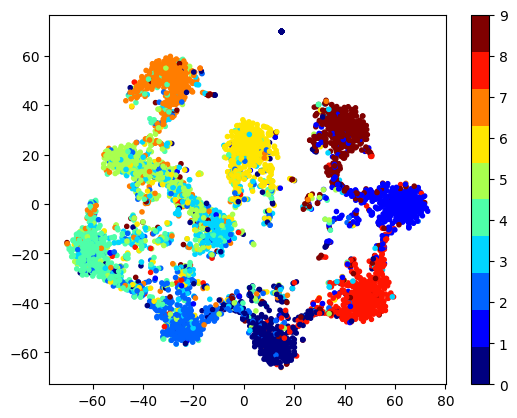

In [ ]:

tranformers=buildTransforms(secondStage=False)
loaders=buildLoaders(dataDir, tranformers, **parameters["dataLoader"])
scaler = torch.cuda.amp.GradScaler()

backbone = models.resnet18(pretrained=False)
tools=setModel(backbone,**parameters["supConLoss"])
model=tools["model"]
checkpoint=torch.load(os.path.join(checkpointDir,"train_best_checkpoint.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
embeddings,labels=computeEmbeddings(loaders["validLoader"], model, scaler)
embeddings_tsne = TSNE(n_jobs=10).fit_transform(embeddings)
vis_x = embeddings_tsne[:, 0]
vis_y = embeddings_tsne[:, 1]
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.show()


<ipython-input-28-e3fd9250f69c>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-28-e3fd9250f69c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See ht

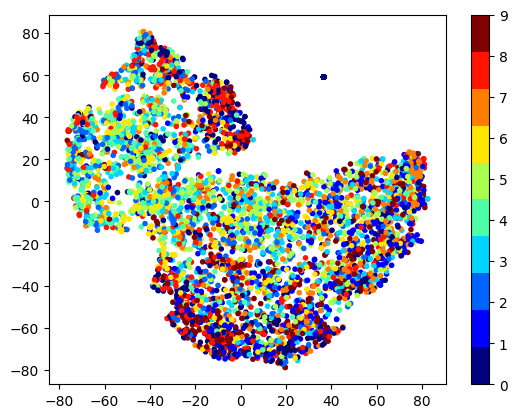

In [ ]:

tranformers=buildTransforms(secondStage=False)
loaders=buildLoaders(dataDir, tranformers, **parameters["dataLoader"])
scaler = torch.cuda.amp.GradScaler()

backbone = models.resnet18(pretrained=False)
tools=setModel(backbone,**parameters["supConLoss"])
model=tools["model"]
checkpoint=torch.load(os.path.join(checkpointDir,"fine_tune_best_checkpoint.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
embeddings,labels=computeEmbeddings(loaders["validLoader"], model, scaler)
embeddings_tsne = TSNE(n_jobs=10).fit_transform(embeddings)
vis_x = embeddings_tsne[:, 0]
vis_y = embeddings_tsne[:, 1]
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.show()


<ipython-input-29-fcfad7727d55>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-29-fcfad7727d55>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See ht

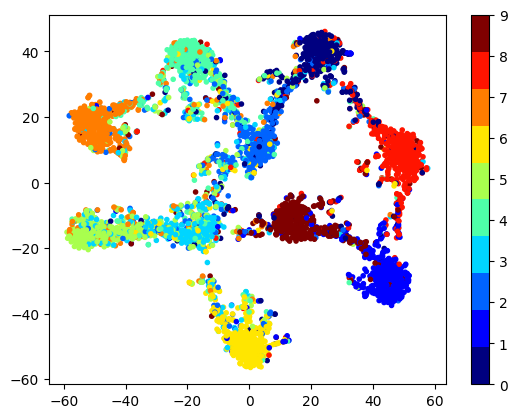

In [ ]:

tranformers=buildTransforms(secondStage=False)
loaders=buildLoaders(dataDir, tranformers, **parameters["dataLoader"])
scaler = torch.cuda.amp.GradScaler()

backbone = models.resnet18(pretrained=False)
tools=setModel(backbone,**parameters["supConLoss"])
model=tools["model"]
checkpoint=torch.load(os.path.join(checkpointDir,"train_best_checkpoint.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
embeddings,labels=computeEmbeddings(loaders["testLoader"], model, scaler)
embeddings_tsne = TSNE(n_jobs=10).fit_transform(embeddings)
vis_x = embeddings_tsne[:, 0]
vis_y = embeddings_tsne[:, 1]
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.show()
